# Premiere partie des resultats

Ici on fait l'experience qui compare les modele entrainer pour converger vers :

1.   Valeurs constante 1/2 tout au long de l'entrainement
2.   Valeurs constante variable / episodes
3.   Valeurs variables par épisodes

Les métriques sont {loss & n_epsiode de convergence & recompense cumulé}

Ensuite on compare l'efficacité pour chacun des cas spécifique --> lequel généralise le plus ?

Utiliser ici l'algorithme DQN pour équivalence avec Tout ou rien.

Un mapping des actions en fonction du dernier etat (x,v) et la consigne est à réaliser.

ajouter l'action dans le modele ? car le DT n'existe pas dans RLlib.. juste GTrXL ?

In [51]:
!pip3 install control
#!pip3 install gymnasium
!pip3 install ray[rllib]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1


## Env Code

In [52]:
# import
import pylab as plt

# Affichage
def plots(X,y,xlabel,ylabel,title,label_c,z=None, label_ph=None,etape=0, show=False):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(X,y, label=label_c)
    if z is not None : ax.plot(X,z, label=label_ph)
    ax.legend()
    if show: plt.show()

In [60]:
import gymnasium as gym
import numpy as np, control as ct
import pandas as pd
import scipy.ndimage as sm
import scipy.optimize as so

from gymnasium import spaces

class LinearSystemControl(gym.Env):
    def __init__(self, config={
                  "env_mode":0,
                  "update_setpoint":True,
                  "reset_X_start":True,
                  "tf":None,
                  "reset":False,
                  "isdiscrete":False,
                  "SpaceState":None,
                  "tf": None,
                  "setpoint":None,
                  "env_config":None,
                  "modular":False,
                  "return_action":True,
                  "return_speed":False,
                  "order":3,
                  "v": [1,1],
                  "t":10,
                  "N":250}
                 ):
        self.config = config
        self.mode = config["env_mode"]
        self.definedSet = config["setpoint"]
        self._order = config["order"]
        self._isdiscrete = config["isdiscrete"]
        self._update_setpoint = config["update_setpoint"]
        self._reset = config["reset"]
        self._return_action = config["return_action"]
        self._reset_start = config["reset_X_start"]
        self._return_speed = config["return_speed"]
        self._rotate = config["modular"]
        self._max_episode_steps = config["N"]
        self.U = config["v"]
        self.T = config["t"]
        # sim
        self._elapsed_steps = 0
        self._life = 3
        self.previous_action = 0.
        # parameter
        if self._isdiscrete :
            self.action_space = spaces.Discrete(3)  # {-1, 0, 1}
        else :
            self.action_space = spaces.Box(low=-1., high=1., shape=(1,), dtype=np.float32) # [-1;1]
        self.dim_obs = 4 if self._return_action else 3
        # StateSpace
        self.ss = pd.Series({"i":0, "s":0, "A":np.array(1), "B":np.array(1), "C":np.array(1), "D":np.array(1)})  if not(isinstance(config["SpaceState"], pd.Series)) else config["SpaceState"]
        # IOSystem U={0,1}, X0=1
        self.dydt = []
        self.X_start = 0.
        self.time = np.linspace(0, self.T, self._max_episode_steps)
        if config["tf"] == None :
          self.sys = self.define_LinearIO(self.ss)
        else :
          self.sys = self.generate_ss_from_tf(*config["tf"])
        # define setpoint
        self.set_setpoint()

    ############ Parameter Part
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def set_setpoint(self, epsilon=0.05):
        # mode : consigne (setpoint in  [0+a,1-a])
        if self.mode == 0 :
            if self.definedSet == None :
              self.setpoint = (self.setmin + self.setmax)/2.
            else :
              self.setpoint = self.definedSet
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin + 2*self.D, self.setmax - 2*self.D)
        else :
            consigne = self.signal_generator(self._max_episode_steps, epsilon=self.D) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin
            self.setpoint = self.all_setpoint[self._elapsed_steps] # prends la derniere valeur

    def define_Boundary(self, sys, d=0.05) :
        # calculate boundary
        _, Y_g = ct.forced_response(sys, self.time, U=-1, X0=self.X_start)
        _, Y_h = ct.forced_response(sys, self.time, U=1, X0=self.X_start)
        # sign in limit --> for order sup 1, find zeros bounds for generalization (zeros = len(fsolve(Y_g - Y_h, [0, self._max_episode_steps])))
        self.sign = (1. if Y_h[-1] > Y_g[-1] else -1.)
        # boundary
        self.min, self.max = min(-1.5, Y_g.min(), Y_h.min()), max(Y_g.max(),Y_h.max(), 1.5)
        # setpoint limit (squeeze theroem : g < f < h) --> NO
        self.setmin, self.setmax = min(Y_h[-1], Y_g[-1]), max(Y_h[-1], Y_g[-1])
        # apply
        self.observation_space = spaces.Box(low=self.min, high=self.max, shape=(self.dim_obs,), dtype=np.float32)
        # basic error 10 %
        self.D = d*(self.setmax - self.setmin)

    ############ Model Part
    def generate_ss_from_tf(self, num=[1], den=[1,1], setpoint=1./2):
        self.setpoint = self.definedSet = setpoint
        # create system
        sys = ct.TransferFunction(num,den)
        sys = ct.tf2ss(sys)
        # extract parameter
        self.ss["A"], self.ss["B"], self.ss["C"], self.ss["D"] = sys.A, sys.B, sys.C, sys.D
        self.ss["i"], self.ss["s"] = 1, sys.nstates
        # bound and simulation parameter
        self.define_Boundary(sys)
        # save
        self._order = self.ss["s"]
        return sys

    def define_LinearIO(self, ss, d=0.05):
        if ss.i == 0 :
          ss["s"] = self._order
          sys = ct.rss(self._order)
          ss["A"], ss["B"], ss["C"], ss["D"] = sys.A, sys.B, sys.C, sys.D
        else :
          sys = ct.StateSpace(ss.A,ss.B,ss.C,ss.D)
          self._order = ss["s"]
        if self._reset_start :
          self.X_start = np.random.choice([-1.,0.,1.])
        # bound and simulation parameter
        self.define_Boundary(sys, d)
        return sys

    ############ Simulation Part
    def reset(self, seed=None, options=None):
        self._life = 3
        # re-init
        if self._reset :
          self.sys = self.define_LinearIO(self.ss)
        if self._update_setpoint :
          self.set_setpoint()
        # 1st step
        self._elapsed_steps, T = 0, self.time[0:2]
        T, Y, X = ct.forced_response(self.sys, T, U=self.U, X0=self.X_start, return_x=True)
        self.V = self.U
        # update
        self._elapsed_steps += 1
        self.X = X[:,1]
        self.previous_action = self.U[-1]
        #return <obs>
        if self._return_speed :
          self.dydt = [(Y[1] - Y[0]) / (T[1] - T[0])]
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[0]],[self.setpoint,0]]
          if self._return_action :
            obs = [[self.previous_action, 0]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [self.previous_action] + obs
        return np.array(obs), {}

    def step(self, action):
        done = False
        # continuous or discrete
        if self._isdiscrete :
            action = action - 1 # {0,1,2} --> {-1, 0, 1}
        else :
            action = float(action)
            if self._rotate :
              action = 1.5*np.sin(action)
            else :
              action = min(max(action,-1.5),1.5)
        # update input
        T = self.time[self._elapsed_steps:self._elapsed_steps+2]
        self.V = [self.V[-1], action]
        # calculate
        T, Y, X = ct.forced_response(self.sys, T, U=self.V, X0=self.X, return_x=True)
        # update output
        self._elapsed_steps += 1
        self.X = X[:,1]
        # reward : Custom reward with HubberLoss (setpoint(t))
        if Y[-1] > (self.setpoint - self.D) and Y[-1] < (self.setpoint + self.D) :
            reward = 1
        else :
            reward = 0
        # outlimit
        if (Y[-1] < self.min) or (Y[-1] > self.max) :
            reward = -1
            self._life -= 1
            if self._life == 0 :
              reward = -10
              done = True
        # limit
        if self._elapsed_steps == self._max_episode_steps - 1 :
            done = True
        # update setpoint
        setpoint = self.setpoint
        if self.mode == 2 :
          self.setpoint = self.all_setpoint[self._elapsed_steps]
        # new state (setpoint(t+1))
        if self._return_speed :
          self.dydt = [self.dydt[-1]] + [(Y[1] - Y[0]) / (T[1] - T[0])]
          dsdt = (self.setpoint - setpoint) / (T[1] - self.time[self._elapsed_steps])
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[1]],[self.setpoint, dsdt]]
          if self._return_action :
            dadt = (action - self.previous_action) / (T[1] - self.time[self._elapsed_steps])
            obs = [[action, dadt]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [action] + obs
        state = np.array(obs)
        # update action
        self.previous_action = action
        # return <obs>, <reward: float>, <done: bool>, <info: dict>
        info = {}
        return state, reward, done, done, info

## Train

In [61]:
od1_config = {
    "env_mode":0,
    "update_setpoint":True,
    "reset_X_start":True,
    "tf":None,
    "reset":False,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([1],[1,1],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "v": [1,1],
    "t":10,
    "N":250
}

### Tout-ou-Rien

In [62]:
# Create the Gym environment
env = LinearSystemControl(od1_config)
# see Order 1
env.sys

StateSpace(array([[-1.]]), array([[1.]]), array([[1.]]), array([[0.]]))

[-1.          0.51932514  0.49861848  0.5       ]


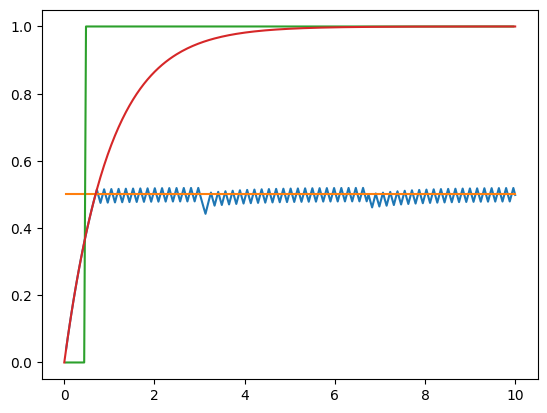

In [63]:
# mode
random = False
perturb = True
# simulation
Y = [env.reset()[0][2:]]
R = []
for i in range(env._max_episode_steps-2) :
  if random :
    action = env.action_space.sample()
  else :
    if Y[-1][0] > env.setpoint :
      action = (-1)*env.sign + 1
    else :
      action = env.sign + 1
  if perturb :
    if np.random.random() > 0.999 :
      action = env.action_space.sample()
  state, reward, done, _, info = env.step(action)
  Y += [state[2:]]
  R += [reward]
  #if done : break
print(state)
# compare
T_OUT, Y_ = ct.forced_response(env.sys, env.time, U=1, X0=env.X_start)
# plot
plt.plot(T_OUT[1:], Y)
plt.plot(T_OUT[1:len(Y)], R)
plt.plot(T_OUT, Y_)
plt.show()

### RLLib

Entrainement https://docs.ray.io/en/latest/rllib/rllib-training.html

In [64]:
from tqdm import tqdm
import ray
from ray.rllib.algorithms import dqn
#from ray.tune.registry import register_env


ray.shutdown()
ray.init()

algo = dqn.DQN(env=LinearSystemControl, config={"env_config": od1_config, "num_workers": 1})
for i in tqdm(range(20)):
  algo.train()

2023-12-16 16:58:50,678	INFO worker.py:1673 -- Started a local Ray instance.
2023-12-16 16:58:52,964	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.LinearSystemControl'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.LinearSystemControl'>').build()` instead. This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationW

In [65]:
algo.train()

{'custom_metrics': {},
 'episode_media': {},
 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0,
     'grad_gnorm': 0.031109701842069626,
     'mean_q': 29.80472183227539,
     'min_q': 19.300813674926758,
     'max_q': 31.102142333984375,
     'cur_lr': 0.0005},
    'td_error': array([ 7.4310303e-03, -7.0558548e-02, -2.7540207e-02,  2.4204254e-03,
            6.8382263e-02,  1.2754250e-01, -2.3939133e-02, -3.1938362e-01,
           -5.8420181e-02, -5.7874680e-02, -6.5237045e-02, -6.6249847e-02,
           -2.1104431e-01,  9.7970963e-02, -5.1765442e-03,  3.0072081e+01,
           -1.0621834e-01, -2.5100708e-02, -2.8699875e-02,  2.9908201e+01,
            2.9967077e+01,  2.9281866e+01,  6.9211960e-02, -1.6691208e-02,
           -5.0605774e-02, -5.2835464e-02, -9.6588135e-02,  1.0433197e-02,
           -1.9042969e-02,  1.4660072e-01, -2.2884369e-02,  1.6011810e-01],
          dtype=float32),
    'mean_td_error': 3.706101655960083,
    'model': {},
    'cu

[1.         0.42283004 0.44555027 0.5       ]


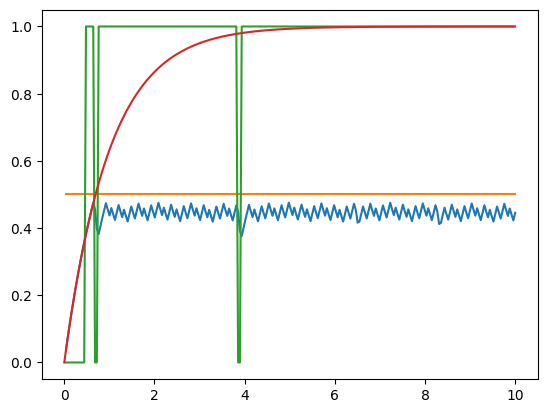

In [66]:
# simulation
state, _ = env.reset()
Y = [state[2:]]
R = []
for i in range(env._max_episode_steps-2) :
  action = algo.compute_single_action(state)
  state, reward, done, _, info = env.step(action)
  Y += [state[2:]]
  R += [reward]
  if done : break
print(state)
# compare
T_OUT, Y_ = ct.forced_response(env.sys, env.time, U=1, X0=env.X_start)
# plot
plt.plot(T_OUT[1:], Y)
plt.plot(T_OUT[1:len(Y)], R)
plt.plot(T_OUT, Y_)
plt.show()

A = [[-1.]]

B = [[1.]]

C = [[1.]]

D = [[0.]]

[-1.         -0.48661247 -0.50682191 -0.56029588]


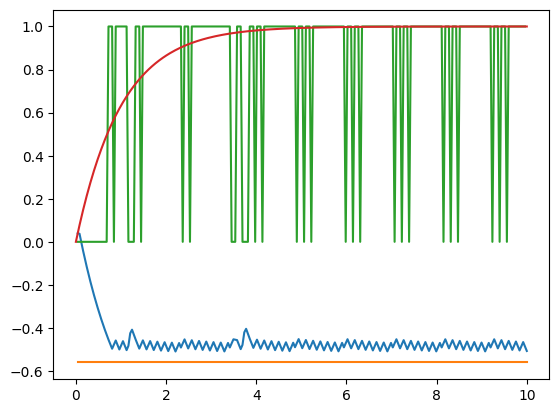

In [90]:
# compare mode 0 --> 2
od1_config = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "tf":None,
    "reset":False,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([1],[1,1],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "v": [1,1],
    "t":10,
    "N":250
}
# Create the Gym environment
env_ = LinearSystemControl(od1_config)
print(env_.sys)
# simulation
state, _ = env_.reset()
Y = [state[2:]]
R = []
for i in range(env._max_episode_steps-2) :
  action = algo.compute_single_action(state)
  state, reward, done, _, info = env_.step(action)
  Y += [state[2:]]
  R += [reward]
  if done : break
print(state)
# compare
T_OUT, Y_ = ct.forced_response(env_.sys, env_.time, U=1, X0=env_.X_start)
# plot
plt.plot(T_OUT[1:], Y)
plt.plot(T_OUT[1:len(Y)], R)
plt.plot(T_OUT, Y_)
plt.show()